This notebook contains a collection of goodness-of-fit tests

In [12]:
import arviz as az
import matplotlib.pyplot as plt
from matplotlib import colors
import numpy as np
import pandas as pd
import pymc3 as pm
from tqdm import tqdm
from sklearn.metrics import *
import theano.tensor as tt
import scipy
import scipy.stats as stats
import seaborn as sns
sns.set(style="darkgrid")

import rasterio as rio
from rasterio import mask
import geopandas as gpd
from shapely.geometry import shape
import xarray as xr
import rioxarray
import fiona

import optuna
import sklearn
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
import xgboost as xgb
from sklearn.model_selection import train_test_split

tqdm.pandas()

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

In [3]:
from models import *

balancing...
repairs: 7.6567198704603285%, non-repairs: 92.34328012953968%
processing soil hydraulic data...
acquiring housing information...
processing DEM and flow information...
fitting water model...


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [c, ppt, wtr_dist, sigma_c, mu_c, ppt_sig, ppt_mu, wtr_beta, wtr_alpha]


Sampling 4 chains for 200 tune and 500 draw iterations (800 + 2_000 draws total) took 27 seconds.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


fitting water distance model...


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [c, wtr_dist, sigma_c, mu_c, wtr_beta, wtr_alpha]


Sampling 4 chains for 200 tune and 500 draw iterations (800 + 2_000 draws total) took 16 seconds.
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated number of effective samples is smaller than 200 for some parameters.


fitting precipitation model...


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [c, ppt, sigma_c, mu_c, ppt_sig, ppt_mu]


Sampling 4 chains for 200 tune and 500 draw iterations (800 + 2_000 draws total) took 57 seconds.
The rhat statistic is larger than 1.2 for some parameters.
The estimated number of effective samples is smaller than 200 for some parameters.


fitting soil model...


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [c, hydr, ppt, wtr_dist, sigma_c, mu_c, hydr_sig, ppt_sig, ppt_mu, wtr_beta, wtr_alpha]


Sampling 4 chains for 200 tune and 500 draw iterations (800 + 2_000 draws total) took 43 seconds.
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated number of effective samples is smaller than 200 for some parameters.


fitting socio model...


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [c, hse, hydr, ppt, wtr_dist, sigma_c, mu_c, hse_sig, hydr_sig, ppt_sig, ppt_mu, wtr_beta, wtr_alpha]


Sampling 4 chains for 200 tune and 500 draw iterations (800 + 2_000 draws total) took 52 seconds.
The acceptance probability does not match the target. It is 0.8659049400466613, but should be close to 0.99. Try to increase the number of tuning steps.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


fitting topo model...


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [c, dem, hse, hydr, ppt, wtr_dist, sigma_c, mu_c, dem_beta, dem_alpha, hse_sig, hydr_sig, ppt_sig, ppt_mu, wtr_beta, wtr_alpha]


Sampling 4 chains for 200 tune and 500 draw iterations (800 + 2_000 draws total) took 80 seconds.
The acceptance probability does not match the target. It is 0.9459398190140302, but should be close to 0.99. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.907452525816349, but should be close to 0.99. Try to increase the number of tuning steps.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


# Goodness-of-Fit Analyses

In general, GoF tests have the following form: $fit - penalty$ (where lower values mean imply better predictive models)

Where the $fit$ typically measures how uncertain the prediction is to variation in parameters: $log(\frac{1}{N}\sum_{i=1}^NP(y|\hat{\theta_i}))$. If for all $\theta_i$, the probability of predicting y is always 1 (certain), then $log(1) = 0$

Where the $penalty$ typically measures the variance of the fitted posterior: $Var_{i=1}^nlog(P(y|\hat{\theta_i}))$

Models summary:
1. _Water model_: __distance to water bodies, annual maxima precipitation__
2. _Soil model_: distance to water bodies, annual maxima precipitation, __soil hydraulic conductivity__
3. _Socio model_: distance to water bodies, annual maxima precipitation, soil hydraulic conductivity, __median housing value__
4. _Topo model_: distance to water bodies, annual maxima precipitation, soil hydraulic conductivity, median housing value, __flow accumulation, elevation__

## 1. Widely Applicable Information Criterion (WAIC)
$fit = \sum_{i=1}^s-2log(\frac{1}{n}\sum_{j=1}^nP(y_i|\hat{\theta_j}))$ (for all points $s$)

$penalty = \sum_{i=1}^sVar_{j=1}^nlog(P(y_i|\hat{\theta_j}))$ (for all points $s$)

Text(0, 0.5, 'WAIC')

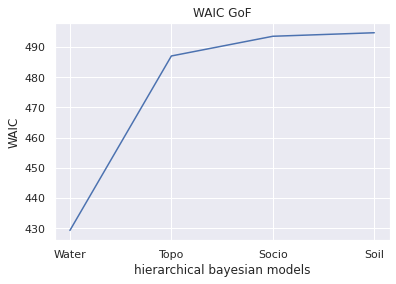

In [4]:
waic_df = pm.compare(traces_dict, ic='WAIC', scale='deviance')
waic_df.reset_index(inplace=True)

# Plot WAIC (lower is better)
ax = waic_df['waic'].plot.line()
ax.set_xticks(range(len(waic_df)))
ax.set_xticklabels(waic_df['index'].values)
ax.set_title('WAIC GoF')
ax.set_xlabel('hierarchical bayesian models')
ax.set_ylabel('WAIC')

Text(0, 0.5, 'WAIC')

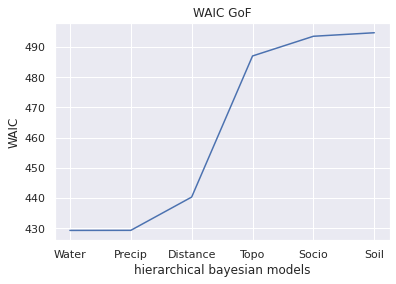

In [5]:
opt_waic_df = pm.compare(opt_traces_dict, ic='WAIC', scale='deviance')
opt_waic_df.reset_index(inplace=True)

# Plot WAIC (lower is better)
ax = opt_waic_df['waic'].plot.line()
ax.set_xticks(range(len(opt_waic_df)))
ax.set_xticklabels(opt_waic_df['index'].values)
ax.set_title('WAIC GoF')
ax.set_xlabel('hierarchical bayesian models')
ax.set_ylabel('WAIC')

## 2. Leave-one-out (LOO) Cross Validation
Train model with (n-k) data points, and perform prediction on k data points. Do this multiple times and average the log likelihood (ie. $fit$).  

Text(0, 0.5, 'LOO-CV')

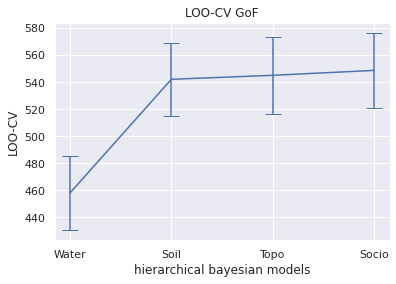

In [6]:
loo_df = pm.compare(traces_dict, ic='LOO', scale='deviance')
loo_df.reset_index(inplace=True)

# Plot LOO-CV (lower is better)
ax = loo_df['loo'].plot.line(yerr=loo_df['se'], capsize=8)
ax.set_xticks(range(len(loo_df)))
ax.set_xticklabels(loo_df['index'].values)
ax.set_title('LOO-CV GoF')
ax.set_xlabel('hierarchical bayesian models')
ax.set_ylabel('LOO-CV')

Text(0, 0.5, 'LOO-CV')

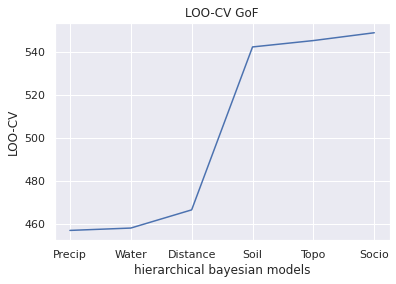

In [21]:
opt_loo_df = pm.compare(opt_traces_dict, ic='LOO', scale='deviance')
opt_loo_df.reset_index(inplace=True)

# Plot LOO-CV (lower is better)
ax = opt_loo_df['loo'].plot.line()
ax.set_xticks(range(len(opt_loo_df)))
ax.set_xticklabels(opt_loo_df['index'].values)
ax.set_title('LOO-CV GoF')
ax.set_xlabel('hierarchical bayesian models')
ax.set_ylabel('LOO-CV')

## 3. Posterior Variance Checks

In [14]:
with topo_model:
    ppc = pm.sample_posterior_predictive(
        topo_trace, var_names=['wtr_dist', 'ppt', 'hydr', 'hse', 'dem', 'failures']
    )

In [17]:
# Compute aprior and fitted posterior SD
post_init_var = []
post_fit_var = []
for param, var in var_dict.items():
    post_init_var.append(round(np.sqrt(topo_priors[param].var()), 2))
    post_fit_var.append(round(np.sqrt(ppc[param].var()), 2))

init_var_df = pd.DataFrame({'Params': var_dict.keys(), 'SD': post_init_var, 'Posterior': 'priori'})
fit_sig_df = pd.DataFrame({'Params': var_dict.keys(), 'SD': post_fit_var, 'Posterior': 'fitted'})

sig_df = pd.concat([init_var_df, fit_sig_df])

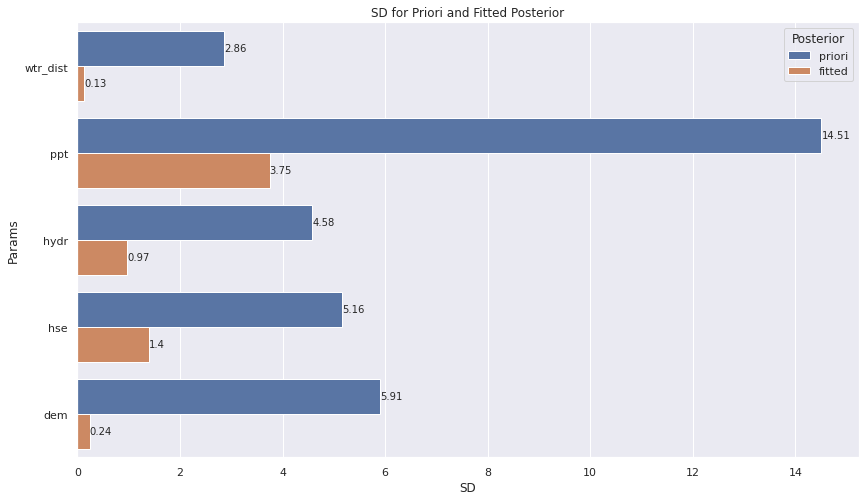

In [18]:
# Plotting
plt.figure(figsize=(14, 8))
ax = sns.barplot(x='SD', y='Params', hue='Posterior', data=sig_df, ci=None, orient='h')
ax.set_title('SD for Priori and Fitted Posterior')
for i in ax.containers:
    ax.bar_label(i,)